In [1]:
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import concatenate
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data= pd.read_csv('/content/drive/My Drive/DS_Project/ML_dataframe.csv', encoding= 'latin1')
data

,Date,Precipitation,Temperature,Relative_humidity,Air_Pressure,PRW
0,1/1/1915,3.372648,275.14020,83.499230,83609.850,2.784520
1,1/2/1915,5.849281,280.52010,88.843410,83221.570,3.970052
2,1/3/1915,0.150792,276.48587,95.272660,83625.350,3.120856
3,1/4/1915,2.477911,279.44635,88.040890,83994.516,2.128633
4,1/5/1915,0.001109,267.71445,80.809130,84009.480,2.024976
...,...,...,...,...,...,...
36495,12/27/2014,4.814195,273.45140,64.560680,83678.870,6.425169
36496,12/28/2014,0.004475,274.76535,63.451500,83346.450,7.488951
36497,12/29/2014,0.000026,272.95187,62.342327,83224.750,7.951182
36498,12/30/2014,0.032887,274.79710,85.251480,83244.586,8.224910


In [4]:
dataset= data[['Precipitation','Temperature', 'Relative_humidity','Air_Pressure','PRW']]

Multivariate Time Series Forecasting with LSTMs in Keras

In [6]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [7]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = pd.DataFrame(series_to_supervised(scaled, 1, 1))
print(type(reframed))
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

<class 'pandas.core.frame.DataFrame'>
          0         1         2         3         4         5
0  0.013658  0.401840  0.735837  0.551811  0.091526  0.023688
1  0.023688  0.511950  0.803938  0.450218  0.135534  0.000611
2  0.000611  0.429381  0.885866  0.555866  0.104011  0.010035
3  0.010035  0.489973  0.793712  0.652458  0.067179  0.000004
4  0.000004  0.249858  0.701557  0.656372  0.063331  0.000053


In [8]:
values = reframed.values
n_train_data = 27375
train = values[:n_train_data, :]
test = values[n_train_data:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(27375, 1, 5) (27375,) (9124, 1, 5) (9124,)


In [9]:
...
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
381/381 - 4s - loss: 0.0151 - val_loss: 0.0150 - 4s/epoch - 10ms/step
Epoch 2/50
381/381 - 1s - loss: 0.0148 - val_loss: 0.0148 - 1s/epoch - 3ms/step
Epoch 3/50
381/381 - 1s - loss: 0.0147 - val_loss: 0.0148 - 1s/epoch - 3ms/step
Epoch 4/50
381/381 - 1s - loss: 0.0146 - val_loss: 0.0147 - 1s/epoch - 3ms/step
Epoch 5/50
381/381 - 1s - loss: 0.0147 - val_loss: 0.0147 - 1s/epoch - 3ms/step
Epoch 6/50
381/381 - 1s - loss: 0.0147 - val_loss: 0.0147 - 1s/epoch - 3ms/step
Epoch 7/50
381/381 - 1s - loss: 0.0147 - val_loss: 0.0149 - 1s/epoch - 3ms/step
Epoch 8/50
381/381 - 1s - loss: 0.0145 - val_loss: 0.0146 - 1s/epoch - 3ms/step
Epoch 9/50
381/381 - 1s - loss: 0.0145 - val_loss: 0.0146 - 1s/epoch - 3ms/step
Epoch 10/50
381/381 - 1s - loss: 0.0145 - val_loss: 0.0146 - 1s/epoch - 3ms/step
Epoch 11/50
381/381 - 1s - loss: 0.0145 - val_loss: 0.0146 - 1s/epoch - 3ms/step
Epoch 12/50
381/381 - 1s - loss: 0.0146 - val_loss: 0.0147 - 1s/epoch - 3ms/step
Epoch 13/50
381/381 - 1s - loss: 0.0

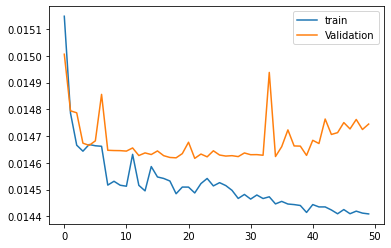

In [10]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [11]:
...
#NEW    make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)

Test RMSE: 9.3136027


In [12]:
from sklearn import metrics
from scipy import stats
print('MSE: ', metrics.mean_squared_error(inv_y, inv_yhat))
print('MAE: ', metrics.mean_absolute_error(inv_y, inv_yhat))
print('R2: ', metrics.r2_score(inv_y, inv_yhat))
print('Correlation: ', stats.pearsonr(inv_y, inv_yhat)[0])
print('RMSLE: ',metrics.mean_squared_log_error(np.absolute(inv_y), np.absolute( inv_yhat)))
print('MAPE: ',metrics.mean_absolute_percentage_error(inv_y, inv_yhat))

MSE:  86.743195
MAE:  3.6410468
R2:  -0.09862650665611161
Correlation:  0.14113413605995428
RMSLE:  1.1092361
MAPE:  1653189800000.0


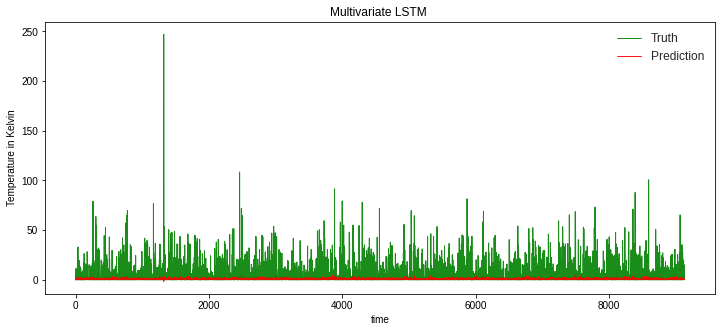

In [13]:
plt.figure(figsize=(12,5))
plt.xlabel('time')
plt.ylabel('Temperature in Kelvin')
plt.title('Multivariate LSTM ')
plt.style.use('seaborn-darkgrid')


plt.plot(inv_y,color='g', linewidth=1, alpha=0.9, label='Truth')
plt.plot(inv_yhat,color='r', linewidth=1, alpha=0.9,label='Prediction')
#plt. text(2,60000, 'RMSE =9916.220', style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.legend(fontsize=12)
plt.show()

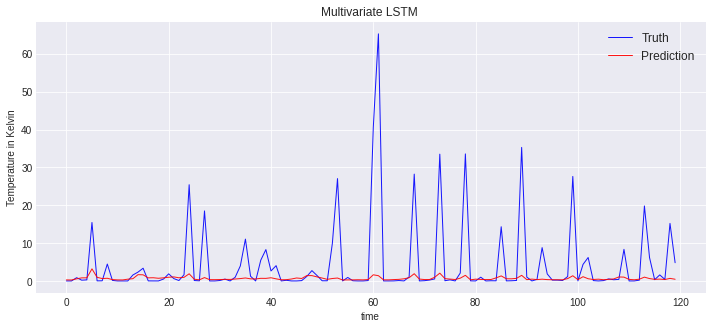

In [14]:
plt.figure(figsize=(12,5))
plt.xlabel('time')
plt.ylabel('Temperature in Kelvin')
plt.title('Multivariate LSTM ')
plt.style.use('seaborn-darkgrid')


plt.plot(inv_y[9000:9120],color='b', linewidth=1, alpha=0.9, label='Truth')
plt.plot(inv_yhat[9001:9121],color='r', linewidth=1, alpha=0.9,label='Prediction')
#plt. text(2,60000, 'RMSE =9916.220', style='italic',bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})
plt.legend(fontsize=12)
plt.show()